# 🎶 Concert Enjoyment Classification – Data Exploration and Base Models
## Project Overview

This project aims to predict a concertgoer’s overall experience by classifying each concert experience into one of four categories: **Worst Concert Ever**, **Did Not Enjoy**, **Enjoyed**, and **Best Concert Ever**.

The prediction is based on information describing the performing band, the venue, concert conditions, and individual concertgoer characteristics. By combining these heterogeneous features, the objective is to estimate how a specific person will experience a specific concert.

## Introduction & Problem Definition
The target variable in this project represents increasing levels of concert enjoyment and therefore has a **natural ordering**. Treating the labels as independent classes would ignore the relative distance between outcomes, even though predicting a nearby category is less severe than predicting an extreme one.

For this reason, the task is framed as an **ordinal classification problem**. The goal is to learn a model that not only predicts the correct class, but also respects the ordered structure of concert enjoyment levels.

This notebook explores the dataset, applies preprocessing and feature engineering, evaluates baseline classifiers, and investigates ordinal-aware models designed to better capture the structure of the problem.

## 1. Exploratory Data Analysis
### 📊 Dataset Description
The dataset contains information describing concert experiences, combining characteristics of the band, the concert, and the concertgoer. Each row represents a single concert experience, defined as a specific concert attended by a specific concertgoer.

The same bands, concerts, and concertgoers appear consistently across both the training and test sets. As a result, patterns learned from these entities in the training data are expected to generalize to the test data.

Due to imperfections in the data-gathering process, some features may not perfectly reflect real-world values. However, the target variable Concert Enjoyment has been verified and is considered fully reliable.

#### Feature Description
| Category | Feature Name | Description |
|----------|--------------|-------------|
| General | Id | Unique identifier of a concert experience |
| Target | Concert Enjoyment | Ordered target variable with four classes: *Worst Concert Ever*, *Did Not Enjoy*, *Enjoyed*, *Best Concert Ever* |
| Band | Band Name | Name of the band performing at the concert |
| Band | Band Genre | Genre of music played by the band |
| Band | Band Debut | Year the band debuted |
| Band | Band Country of Origin | Country where the band originated |
| Concert | Concert ID | Unique identifier of a specific concert |
| Concert | Concert Attendance | Number of attendees at the concert |
| Concert | Inside Venue | Indicates whether the venue is indoors |
| Concert | Rain | Indicates whether it rained during the concert |
| Concertgoer | Concert Goer ID | Unique identifier of a concertgoer |
| Concertgoer | Concert Goer Age | Age of the concertgoer (as of 2022) |
| Concertgoer | Height (cm) | Height of the concertgoer in centimeters |
| Concertgoer | Seated | Whether the concertgoer was seated during the concert |
| Concertgoer | Concert Goer Country of Origin | Country of origin of the concertgoer |
| Concertgoer | Personality Trait 1–4 | Self-assessed personality traits of the concertgoer |

This section explores the following
- Distribution of concert enjoyment classes
- Analysis of band, concert, and concertgoer features
- Identification of missing values, noisy variables, and potential data inconsistencies
- Key insights guiding preprocessing and model selection

In [2]:
# installations
# !pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install sklearn
#!pip install spacecutter
#!pip install skorch
#!pip install seaborn
#!pip install graphviz
#!pip install mord
#%pip install -U seaborn

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score
from sklearn.svm import LinearSVC


from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.model_selection import StratifiedKFold

import graphviz
from mord import OrdinalRidge

from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv("train.csv" )
df_test = pd.read_csv("test.csv" )

# 1.1 Basic information of the data

In [4]:
df.head()

,Id,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin,Concert Enjoyment
0,ConcertExperience_180106,Teenage Crazy Blue Knickers,Indie/Alt Rock,United States of America (USA),1976.0,900.0,2980.0,False,False,NaN,0.330843,-0.958408,-0.943548,-1.636806,29.0,concert_goer_1985,140.0,Paraguay,Did Not Enjoy
1,ConcertExperience_146268,Beyond Devon,Pop Music,United States of America (USA),1968.0,731.0,54.0,True,False,True,-2.069449,0.017777,-1.910675,0.610265,43.0,concert_goer_1874,158.0,United Kingdom (UK),Enjoyed
2,ConcertExperience_128743,Ron Talent,Rock n Roll,Canada,1955.0,NaN,162754.0,False,False,True,-0.484268,1.968772,-0.064167,-1.260871,68.0,concert_goer_442,159.0,United States of America (USA),Did Not Enjoy
3,ConcertExperience_140839,Devon Revival,RnB,United States of America (USA),1992.0,704.0,8103.0,False,True,False,-0.858054,1.022827,-0.348389,-1.147251,17.0,concert_goer_1149,150.0,Canada,Worst Concert Ever
4,ConcertExperience_19149,Beyond Devon,Pop Music,United States of America (USA),1968.0,95.0,54.0,False,False,False,-0.793029,-1.166528,-0.043766,0.969661,59.0,concert_goer_930,166.0,United Kingdom (UK),Did Not Enjoy


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170000 entries, 0 to 169999
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Id                              170000 non-null  object 
 1   Band Name                       169141 non-null  object 
 2   Band Genre                      169116 non-null  object 
 3   Band Country of Origin          169210 non-null  object 
 4   Band Debut                      169143 non-null  float64
 5   Concert ID                      169130 non-null  float64
 6   Concert Attendance              169105 non-null  float64
 7   Inside Venue                    169162 non-null  object 
 8   Rain                            169139 non-null  object 
 9   Seated                          169168 non-null  object 
 10  Personnality Trait 1            169148 non-null  float64
 11  Personnality Trait 2            169151 non-null  float64
 12  Personnality Tra

We observe that the dataset has 
- 9 numerical columns and 10 categorical columns.
- All the columns except *Id* and *Concert Enjoyment* has missing values

In [6]:
# Getting an high overview of the distribution of the numerical columns
df.describe()

,Band Debut,Concert ID,Concert Attendance,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Height (cm)
count,169143.000000,169130.000000,1.691050e+05,169148.000000,169151.000000,169107.000000,169135.000000,169147.000000,169153.000000
mean,1985.895053,499.360587,2.727906e+05,0.030190,-7.776188,-0.017279,0.003432,46.979822,164.660680
std,16.365288,288.640600,1.641506e+07,0.992067,3237.713866,1.004774,1.006310,17.470503,14.365046
min,1955.000000,0.000000,5.400000e+01,-3.124408,-293861.500146,-3.275108,-3.287787,16.000000,140.000000
25%,1976.000000,249.000000,4.030000e+02,-0.638873,-0.689943,-0.711015,-0.698374,32.000000,152.000000
50%,1988.000000,500.000000,2.980000e+03,0.022664,-0.021836,0.010071,0.015264,47.000000,164.000000
75%,1998.000000,749.750000,2.202600e+04,0.698236,0.648032,0.680300,0.700369,63.000000,177.000000
max,2014.000000,999.000000,1.627540e+09,3.628828,325834.016795,3.308810,3.830923,76.000000,190.000000


In [7]:
# Getting an high overview of the distribution of the categorical columns
df.describe(include='object')

,Id,Band Name,Band Genre,Band Country of Origin,Inside Venue,Rain,Seated,Concert Goer ID,Concert Goer Country of Origin,Concert Enjoyment
count,170000,169141,169116,169210,169162,169139,169168,169185,169141,170000
unique,170000,54,8,4,2,2,2,2000,152,4
top,ConcertExperience_180106,Ron's Midnight Jockies,Hip Hop/Rap,United States of America (USA),False,False,False,concert_goer_1501,Canada,Enjoyed
freq,1,5080,47820,115423,85348,135408,84786,114,83129,68026


## 1.2 Exploring Bands Column

### 1.2.1 Number of Unique Bands

In [8]:
print("Number of Bands: " , len(df["Band Name"].unique()))

Number of Bands:  55


### 1.2.2 Most watched Bands 

In [9]:
print("Most Watched Bands")
df["Band Name"].value_counts().head(10)

Most Watched Bands


Band Name
Ron's Midnight Jockies                 5080
Crazy Crazy                            4929
Twilight of the Joystick Gods          4402
Running Twins                          4219
Rubbish Devon Frogs                    4083
Ron Nor                                4083
Puddle of Joystick                     4046
The Crazy R Experience                 3891
Crazy Dream and a Pinch of Joystick    3874
Devon Revival                          3835
Name: count, dtype: int64

### 1.2.3 Bands Ranking by Concert goer

In [10]:
bands_ranking = df.pivot_table(index = ["Band Name"] , columns = "Concert Enjoyment" ,fill_value=0, values ="Id" , aggfunc= "count", margins = True )
bands_ranking = bands_ranking.div(bands_ranking["All"] , axis = 0)
format_dict = {
    'Best Concert Ever': '{:,.0%}',
    'Did Not Enjoy': '{:,.0%}',
    'Enjoyed': '{:,.0%}',
    'Worst Concert Ever': '{:,.0%}',
    'All' :  '{:,.0%}',
    "Positive Experience": "{:,.0%}"
}
bands_ranking_ = bands_ranking

In [11]:
bands_ranking_.head().style.format(format_dict)

Concert Enjoyment,Best Concert Ever,Did Not Enjoy,Enjoyed,Worst Concert Ever,All
Band Name,,,,,
A Dozen Running Iced Frogs,2%,56%,32%,10%,100%
Allo Knickers,1%,55%,39%,5%,100%
Beyond Devon,30%,12%,58%,0%,100%
Big Autumn,10%,31%,57%,1%,100%
Big Division,4%,42%,51%,2%,100%


The 10 Worst Ranked Bands 

In [12]:
print("The 10 worst ranked bands")
bands_ranking.sort_values("Worst Concert Ever" , ascending =False).head(10).style.format(format_dict)

The 10 worst ranked bands


Concert Enjoyment,Best Concert Ever,Did Not Enjoy,Enjoyed,Worst Concert Ever,All
Band Name,,,,,
The Big Service,0%,49%,3%,48%,100%
"My Heart, Your Thighs",0%,53%,5%,41%,100%
Ron Talent,0%,58%,6%,36%,100%
Running at the Disco,0%,58%,6%,36%,100%
Crazy Crazy,0%,60%,6%,34%,100%
Devon Revival,0%,60%,8%,32%,100%
"Why Frogs, Why?",0%,58%,16%,25%,100%
Frogsica,0%,63%,13%,24%,100%
Crazy Dream and a Pinch of Joystick,0%,65%,11%,24%,100%


The Top 10 Ranked Bands

In [13]:
print("The Top 10 ranked bands")
bands_ranking.sort_values("Best Concert Ever" , ascending =False).head(10).style.format(format_dict)

The Top 10 ranked bands


Concert Enjoyment,Best Concert Ever,Did Not Enjoy,Enjoyed,Worst Concert Ever,All
Band Name,,,,,
The Crazy Heroes of Devon,43%,3%,55%,0%,100%
The Running Crazy Jockies,41%,5%,54%,0%,100%
Knickers A Dozen,34%,10%,56%,0%,100%
Beyond Devon,30%,12%,58%,0%,100%
This Joystick,28%,8%,64%,0%,100%
Big Frogs Dream,27%,16%,57%,0%,100%
Twilight of the Joystick Gods,27%,14%,58%,1%,100%
Ron Nor,27%,10%,63%,0%,100%
Crazyplay,23%,15%,62%,0%,100%


#### Conclusion 
1.   The Enjoyment of a concert seems to greatly depend on the band performing. Some bands had a great amount of bad reviews while some on the reverse, had lots of good reviews with only few concertgoers not liking them. This will be helpful to our predictions.

2.   The categorical Enjoyment is well ranked and meaningful and should be taken into consideration i.e. if a Band had a high percentage of "Best Concert Ever" ranking, the "Enjoyed" ranking will also be high while the "Did not Enjoy" ranking will be low with "Worst concert Ever" being the lowest. 

### 1.2.4 Band Genre

In [14]:
band_genre = df["Band Genre"].value_counts().sort_index()
band_genre = pd.DataFrame({"Band Genre": band_genre.index , "Watched Concerts" : band_genre.values})
band_genre = band_genre.sort_values("Watched Concerts" , ascending = False)
band_genre

,Band Genre,Watched Concerts
2,Hip Hop/Rap,47820
5,Pop Music,26175
1,Heavy Metal,25334
7,Rock n Roll,24193
6,RnB,23748
3,Indie/Alt Rock,16858
0,Country,4907
4,Insert Band Genre,81


In [15]:
print("Ranking based on Band Genre")
genre_band_ranking = df.pivot_table(index="Band Genre", columns="Concert Enjoyment" ,fill_value=0, aggfunc="size")
genre_band_ranking["All"] = genre_band_ranking.sum(axis=1)
genre_band_ranking = genre_band_ranking.div(genre_band_ranking["All"], axis=0)
genre_band_ranking["Positive Experience"] = (genre_band_ranking["Best Concert Ever"] + genre_band_ranking["Enjoyed"])
genre_band_ranking = genre_band_ranking.sort_values(by="Positive Experience", ascending=False)
genre_band_ranking.style.format(format_dict)

Ranking based on Band Genre


Concert Enjoyment,Best Concert Ever,Did Not Enjoy,Enjoyed,Worst Concert Ever,All,Positive Experience
Band Genre,,,,,,
Country,13%,32%,54%,1%,100%,67%
Indie/Alt Rock,11%,31%,53%,5%,100%,65%
Hip Hop/Rap,12%,36%,45%,6%,100%,58%
Pop Music,15%,35%,40%,9%,100%,55%
Rock n Roll,9%,44%,40%,7%,100%,49%
Insert Band Genre,7%,48%,40%,5%,100%,47%
Heavy Metal,6%,48%,29%,17%,100%,35%
RnB,5%,49%,27%,19%,100%,32%


#### Conclusion:
1. Country genre has the best ranking a cummulative of 67% for positive experience.
2. While, RnB has the worst rankings with a cummulative of 32% for positive experience.
3. The other genres are in between. 
- This can also be useful for our prediction.

### 1.2.5 Band Debut 

<Axes: xlabel='Band Debut period'>

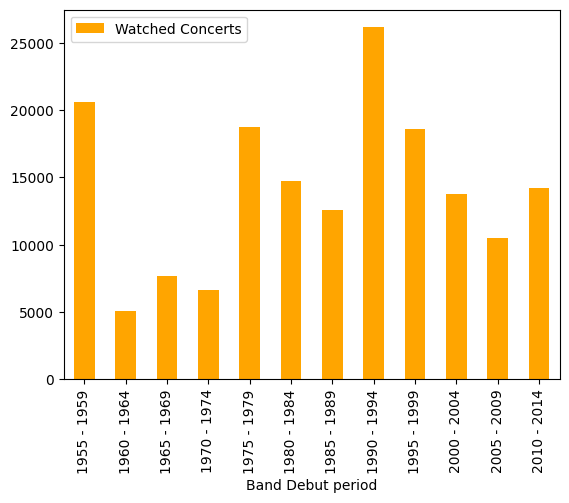

In [16]:
df["Band Debut period"] = pd.cut(df["Band Debut"], bins= [i for i in range(1954 , 2015,5)] , labels = [str(i + i%5   ) + " - " + str(i + i%5+4)  for i in range(1955 , 2015,5)])
band_debut_category = df["Band Debut period"].value_counts().sort_index()
band_debut_category = pd.DataFrame({"Band Debut period": band_debut_category.index , "Watched Concerts" : band_debut_category.values})
band_debut_category.plot.bar(x = "Band Debut period" , y = "Watched Concerts"  , color = "orange"  )

In [17]:
print("Ranking based on Band Debut year")
debut_band_ranking = df.pivot_table(index="Band Debut period", columns="Concert Enjoyment", fill_value=0, aggfunc= "count", values="Id", observed=False)
debut_band_ranking["All"] = debut_band_ranking.sum(axis=1)
debut_band_ranking = debut_band_ranking.div(debut_band_ranking["All"] , axis = 0)
debut_band_ranking["Positive Experience"] = (debut_band_ranking["Best Concert Ever"] + debut_band_ranking["Enjoyed"])
debut_band_ranking = debut_band_ranking.sort_values(by="Positive Experience", ascending=False)
debut_band_ranking.style.format(format_dict)

Ranking based on Band Debut year


Concert Enjoyment,Best Concert Ever,Did Not Enjoy,Enjoyed,Worst Concert Ever,All,Positive Experience
Band Debut period,,,,,,
1970 - 1974,13%,28%,58%,1%,100%,71%
1960 - 1964,5%,37%,58%,1%,100%,63%
1965 - 1969,13%,36%,43%,8%,100%,56%
1985 - 1989,13%,40%,41%,6%,100%,54%
1995 - 1999,15%,36%,39%,11%,100%,53%
1975 - 1979,9%,41%,42%,8%,100%,51%
1980 - 1984,12%,44%,38%,6%,100%,50%
2005 - 2009,10%,37%,40%,13%,100%,50%
1955 - 1959,12%,37%,37%,15%,100%,48%


Conclusion
- Bands created between 1970 and 1974 seem to have higher rating
- Bands between 1960 to 1984 range (excluding the 1970-1974 range) seem to have medium to medium high ratings
- Bands created between 1990-2004 range (excluding the 1995-1999 range) seem to have the worst ratings.

There seem to be some interesting pattern here.

### 1.2.6 Bands Ranking based on Country of Origin

In [18]:
band_country = df["Band Country of Origin"].value_counts().sort_index()
band_country = pd.DataFrame({"Band Country of Origin": band_country.index , "Watched Concerts" : band_country.values})
band_country = band_country.sort_values("Watched Concerts" , ascending = False)
band_country

,Band Country of Origin,Watched Concerts
3,United States of America (USA),115423
0,Canada,42979
2,United Kingdom (UK),10628
1,Insert Band Country of Origin,180


In [19]:
country_band_ranking = df.pivot_table(index = ["Band Country of Origin"] , columns = "Concert Enjoyment" ,fill_value=0, values ="Id" , aggfunc= "count")
country_band_ranking["All"] = country_band_ranking.sum(axis=1)
country_band_ranking = country_band_ranking.div(country_band_ranking["All"] , axis = 0)
country_band_ranking["Positive Experience"] = (country_band_ranking["Best Concert Ever"] + country_band_ranking["Enjoyed"])
country_band_ranking = country_band_ranking.sort_values(by="Positive Experience", ascending=False)
country_band_ranking.style.format(format_dict)

Concert Enjoyment,Best Concert Ever,Did Not Enjoy,Enjoyed,Worst Concert Ever,All,Positive Experience
Band Country of Origin,,,,,,
United Kingdom (UK),15%,20%,64%,0%,100%,79%
Insert Band Country of Origin,11%,36%,43%,10%,100%,54%
United States of America (USA),11%,39%,40%,10%,100%,51%
Canada,6%,47%,34%,13%,100%,40%


Conclusion:
1.   All the Bands are from three Countries : US, Canada and UK. Canada has the worst ratings, the US is in the middle while the UK has the highest Rankings.
2. This surely seems like an important column for our prediction.




RnB and Heavy Metal are the worst !! while Country is the least hated . 

## 1.3 Exploring Concertgoer Columns

### 1.3.1 Exploring Concertgoers' Height

#### 1.3.1.1 Evaluating the Height distribution

In [20]:
np.sort(df["Height (cm)"].unique())

array([140., 141., 142., 143., 144., 145., 146., 147., 148., 149., 150.,
       151., 152., 153., 154., 155., 156., 157., 158., 159., 160., 161.,
       162., 163., 164., 165., 166., 167., 168., 169., 170., 171., 172.,
       173., 174., 175., 176., 177., 178., 179., 180., 181., 182., 183.,
       184., 185., 186., 187., 188., 189., 190.,  nan])

In [21]:
df["Height"] = pd.cut(df["Height (cm)"], bins= [i for i in range(139 , 190,5)] , labels = [str(i + i%5   ) + " - " + str(i + i%5+4)  for i in range(140 , 190,5)])
height_category = df["Height"].value_counts().sort_index()
height_category = pd.DataFrame({"Height": height_category.index , "Watched Concerts" : height_category.values})
height_category

,Height,Watched Concerts
0,140 - 144,15363
1,145 - 149,15992
2,150 - 154,18497
3,155 - 159,17356
4,160 - 164,17863
5,165 - 169,17016
6,170 - 174,17629
7,175 - 179,15898
8,180 - 184,15465
9,185 - 189,15426


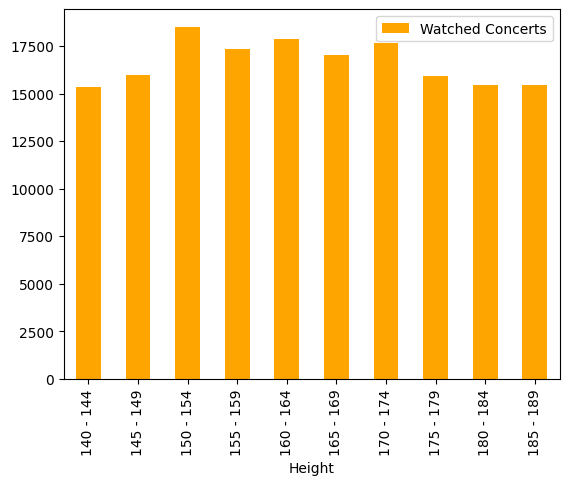

In [22]:
ax = height_category.plot.bar(x = "Height" , y = "Watched Concerts"  , color = "orange"  )


Conclusion:

1.   This height distribution seem unusual because a typical height distribution has is normal (Gaussian). In other words, the number of people of height 185-190 should be way lower what is present in the date .
2.   In addition, there is no concertgoer with a Height higher than 190 which is unlikely. 
 

#### 1.3.1.2 Concert Ranking Based on Concertgoers Height

In [23]:
height_ranking = df.pivot_table(index = ["Height"] , columns = "Concert Enjoyment" ,fill_value=0, values ="Id" , aggfunc= "count", margins = True, observed=False )
height_ranking = height_ranking.div(height_ranking["All"] , axis = 0)
height_ranking_ = height_ranking

In [24]:
height_ranking_.style.format(format_dict)

Concert Enjoyment,Best Concert Ever,Did Not Enjoy,Enjoyed,Worst Concert Ever,All
Height,,,,,
140 - 144,10%,40%,40%,10%,100%
145 - 149,10%,40%,40%,10%,100%
150 - 154,10%,41%,39%,10%,100%
155 - 159,11%,39%,40%,10%,100%
160 - 164,10%,40%,40%,10%,100%
165 - 169,10%,40%,40%,10%,100%
170 - 174,11%,39%,41%,10%,100%
175 - 179,9%,41%,39%,10%,100%
180 - 184,10%,40%,40%,10%,100%


#### 1.3.1.3 Concert Ranking Based on Concertgoers Height and Being Seated at the concert

In [25]:
height_ranking = df.pivot_table(index = ["Height","Seated"] , columns = "Concert Enjoyment" ,fill_value=0, values ="Id" , aggfunc= "count", margins = True, observed=True)
height_ranking = height_ranking.div(height_ranking["All"] , axis = 0)
height_ranking_ = height_ranking

In [26]:
height_ranking_.style.format(format_dict)

Conclusion:

1.   Here, we observed further if the height and not being seated features led to unsatisfaction with the concert, but we still found no correlation. This reaffirms our Hypothesis that the Height data is not inaccurate. 
2.   We can confirm that there seem to be no Correlation between Height and the Enjoyment of a Concert



### 1.3.2 Exploring Concertgoers' Age 

#### 1.3.2.1 Evaluating the Age distribution


In [27]:
np.sort(df["Concert Goer Age"].unique())

array([16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
       42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54.,
       55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67.,
       68., 69., 70., 71., 72., 73., 74., 75., 76., nan])

In [28]:
df["Age"] = pd.cut(df["Concert Goer Age"], bins= [i for i in range(14 , 80,5)] , labels = [str(i + i%5   ) + " - " + str(i + i%5+4)  for i in range(15 , 80,5)])
age_category = df["Age"].value_counts().sort_index()
age_category = pd.DataFrame({"Age": age_category.index , "Watched Concerts" : age_category.values})
age_category

,Age,Watched Concerts
0,15 - 19,9326
1,20 - 24,12842
2,25 - 29,13137
3,30 - 34,13259
4,35 - 39,14247
5,40 - 44,13673
6,45 - 49,14792
7,50 - 54,14041
8,55 - 59,13876
9,60 - 64,14062


<Axes: xlabel='Age'>

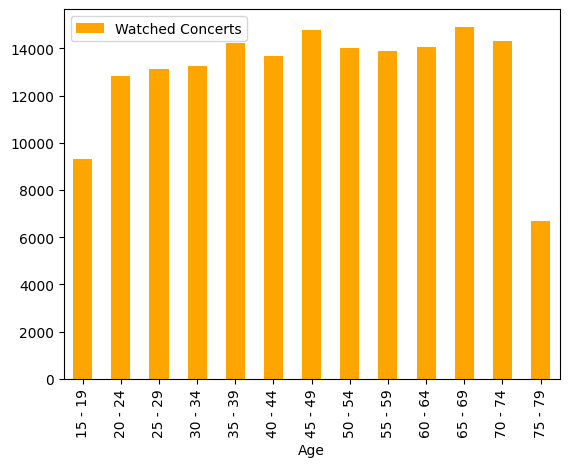

In [29]:
age_category.plot.bar(x = "Age" , y = "Watched Concerts"  , color = "orange"  )

#### 1.3.2.2 Concert Ranking Based On Age

In [30]:
age_ranking = df.pivot_table(index = ["Age"] , columns = "Concert Enjoyment" ,fill_value=0, values ="Id" , aggfunc= "count", observed=True )
age_ranking["All"] = age_ranking.sum(axis=1)
age_ranking = age_ranking.div(age_ranking["All"] , axis = 0)
age_ranking["Positive Experience"] = (age_ranking["Best Concert Ever"] + age_ranking["Enjoyed"])
age_ranking = age_ranking.sort_values(by="Positive Experience", ascending=False)
age_ranking.style.format(format_dict)

Concert Enjoyment,Best Concert Ever,Did Not Enjoy,Enjoyed,Worst Concert Ever,All,Positive Experience
Age,,,,,,
25 - 29,14%,35%,44%,6%,100%,58%
20 - 24,15%,36%,43%,6%,100%,58%
15 - 19,13%,36%,43%,7%,100%,57%
45 - 49,12%,39%,42%,7%,100%,54%
35 - 39,11%,39%,43%,8%,100%,54%
30 - 34,11%,39%,42%,8%,100%,53%
40 - 44,11%,40%,41%,7%,100%,53%
50 - 54,9%,42%,39%,11%,100%,48%
55 - 59,8%,42%,38%,12%,100%,46%


#### Conclusion:

- Age seems to be inversely correlated to a concert enjoyment i.e. the older the concertgoer is, the more likely they will rank the concert as "Did Not Enjoy" or "Worst Concert Ever"!! 

### 1.3.3 Exploring Concertgoers' Country of Origin

#### 1.3.3.1 Evaluating the Concertgoer Country of Origin Distribution

In [31]:
df["Concert Goer Country of Origin"].unique()

array(['Paraguay', 'United Kingdom (UK)',
       'United States of America (USA)', 'Canada', 'Maldives', 'Niger',
       'Latvia', 'Vanuatu', 'Vatican City (Holy See)', 'Sweden',
       'Comoros', 'Lebanon', 'Switzerland', 'Barbados', 'Belize', 'China',
       'Japan', 'Luxembourg', 'Bulgaria', 'New Zealand', 'Djibouti',
       'Bolivia', 'Kazakhstan', 'Suriname', 'Monaco', 'Kyrgyzstan',
       'Nigeria', 'Bahrain', 'Somalia', 'Tanzania', 'Uganda',
       'United Arab Emirates (UAE)', 'Greece', 'Taiwan', 'Ecuador',
       'Palestine', 'South Africa', 'Moldova', 'Cameroon',
       'Liechtenstein', 'Laos', 'Jordan', 'Philippines', 'Jamaica',
       'Zimbabwe', 'Romania', 'Sierra Leone',
       'Central African Republic (CAR)', 'Ghana', 'South Sudan',
       'Burundi', 'Eswatini', 'Ireland', 'Botswana', 'Mauritania', nan,
       'Thailand', 'Serbia', 'Malaysia', 'Iceland', 'Brazil', 'Algeria',
       'Cabo Verde', 'Chile', 'Sudan', 'Myanmar', 'Peru', 'Seychelles',
       'Antigua and Barb

In [32]:
concert_goer_country = df["Concert Goer Country of Origin"].value_counts().sort_index()
concert_goer_country = pd.DataFrame({"Concert Goer Country of Origin": concert_goer_country.index , "Watched Concerts" : concert_goer_country.values})
concert_goer_country = concert_goer_country.sort_values("Watched Concerts" , ascending = False)
concert_goer_country

,Concert Goer Country of Origin,Watched Concerts
24,Canada,83129
144,United States of America (USA),52134
143,United Kingdom (UK),9147
37,Djibouti,501
124,Somalia,452
...,...,...
63,Japan,67
121,Slovakia,66
36,Denmark,65
2,Andorra,59


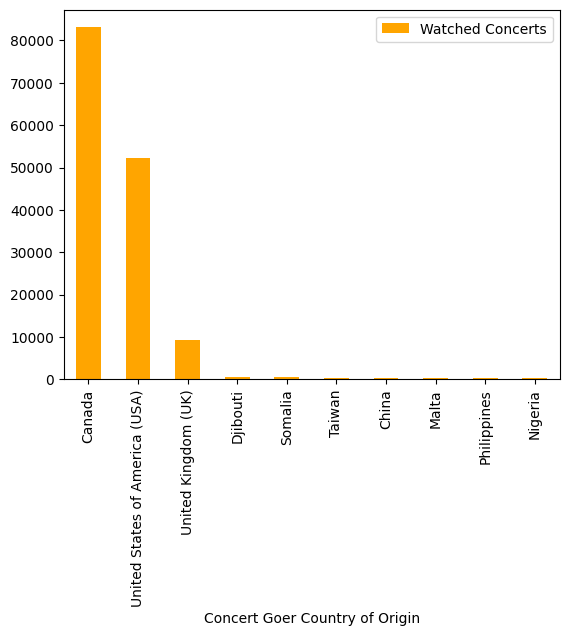

In [33]:
ax = concert_goer_country.head(10).plot.bar(x = "Concert Goer Country of Origin" , y = "Watched Concerts"  , color = "orange"  )

#### Conclusion:

- Canadians, USA and UK had the highest concertgoers with Canadians being the highest

#### 1.3.3.2 Concert Ranking Based On Concertgoer's Country of Origin

In [34]:
country_ranking = df.pivot_table(index = ["Concert Goer Country of Origin"] , columns = "Concert Enjoyment" ,fill_value=0, values ="Id" , aggfunc= "count")
country_ranking["All"] = country_ranking.sum(axis=1)
country_ranking = country_ranking.div(country_ranking["All"] , axis = 0)
country_ranking["Positive Experience"] = (country_ranking["Best Concert Ever"] + country_ranking["Enjoyed"])
country_ranking = country_ranking.sort_values(by="Positive Experience", ascending=False)

Least Satisfied Countries of Origin

In [35]:
country_ranking.tail(10).style.format(format_dict)

Concert Enjoyment,Best Concert Ever,Did Not Enjoy,Enjoyed,Worst Concert Ever,All,Positive Experience
Concert Goer Country of Origin,,,,,,
Slovakia,6%,42%,29%,23%,100%,35%
Belize,6%,47%,29%,18%,100%,35%
Chad,5%,50%,28%,17%,100%,33%
Moldova,3%,51%,31%,16%,100%,33%
Indonesia,8%,47%,25%,20%,100%,33%
Honduras,3%,47%,30%,20%,100%,33%
North Korea,2%,51%,30%,16%,100%,32%
Croatia,4%,48%,28%,20%,100%,32%
Lesotho,3%,51%,27%,20%,100%,29%


Top Satisfied Countries of Origin

In [36]:
country_ranking.head(10).style.format(format_dict)

Concert Enjoyment,Best Concert Ever,Did Not Enjoy,Enjoyed,Worst Concert Ever,All,Positive Experience
Concert Goer Country of Origin,,,,,,
Zimbabwe,14%,27%,55%,3%,100%,70%
Equatorial Guinea,18%,29%,46%,8%,100%,63%
Albania,15%,31%,47%,6%,100%,63%
Comoros,25%,30%,37%,8%,100%,62%
Slovenia,10%,33%,51%,5%,100%,62%
Finland,9%,32%,52%,8%,100%,60%
Belgium,13%,32%,47%,8%,100%,60%
Gambia,12%,36%,48%,5%,100%,60%
Portugal,10%,33%,49%,9%,100%,58%


#### Conclusion:
- Some countries of origin seem generally more satisfied than others. This seems like a useful feature for our prediction.

### 1.3.4 Exploring Concertgoers' Personality Trait 

#### 1.3.4.1 Exploring the Concertgoers' Personality Trait Distribution

The Personality Traits 1,3 and 4 has a similar distribution, so we represented them with just one of them while that of Personality trait 2 is different and has it own representations. 

##### 1.3.4.1.1 Personality Trait 1, 3 and 4

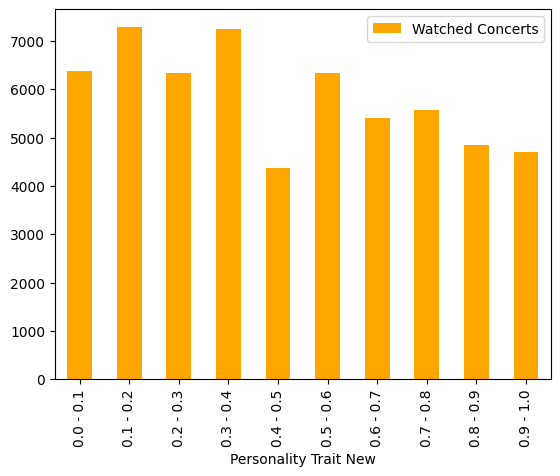

In [37]:
df["Personality Trait New"] = pd.cut(df["Personnality Trait 3"], bins= [i/10 for i in range(0 , 11,1)]  , labels = [str(i/10   ) + " - " + str((i+1)/10 )  for i in range(0 ,10,1)] )
band_debut_category = df["Personality Trait New"].value_counts().sort_index()
band_debut_category = pd.DataFrame({"Personality Trait New": band_debut_category.index , "Watched Concerts" : band_debut_category.values})
ax = band_debut_category.plot.bar(x = "Personality Trait New" , y = "Watched Concerts"  , color = "orange")

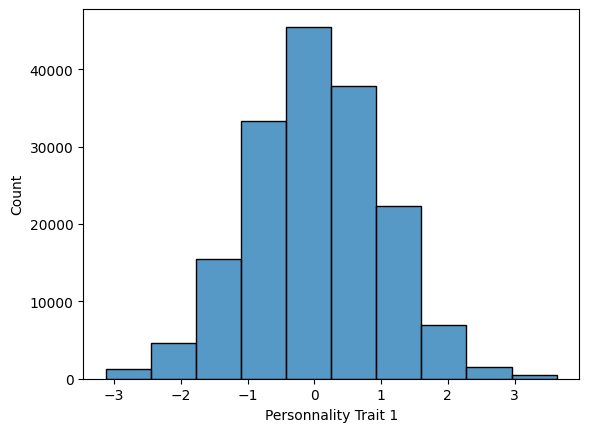

In [38]:
ax = sns.histplot(df["Personnality Trait 1"], bins=10, kde=False)

##### 1.3.4.1.2 Personality Trait 2

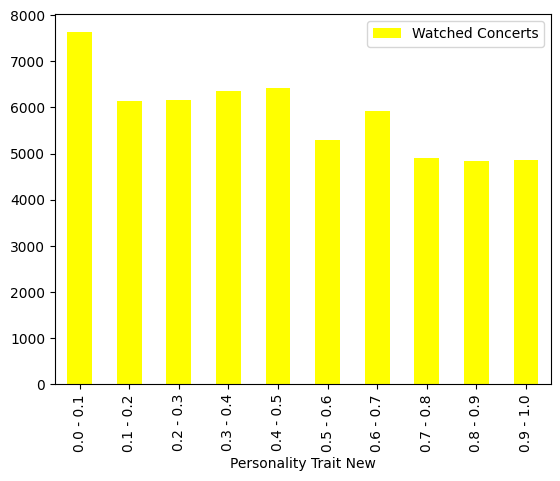

In [39]:
df["Personality Trait New"] = pd.cut(df["Personnality Trait 2"], bins= [i/10 for i in range(0 , 11,1)]  , labels = [str(i/10   ) + " - " + str((i+1)/10 )  for i in range(0 ,10,1)] )
band_debut_category = df["Personality Trait New"].value_counts().sort_index()
band_debut_category = pd.DataFrame({"Personality Trait New": band_debut_category.index , "Watched Concerts" : band_debut_category.values})
ax = band_debut_category.plot.bar(x = "Personality Trait New" , y = "Watched Concerts"  , color = "yellow"  )

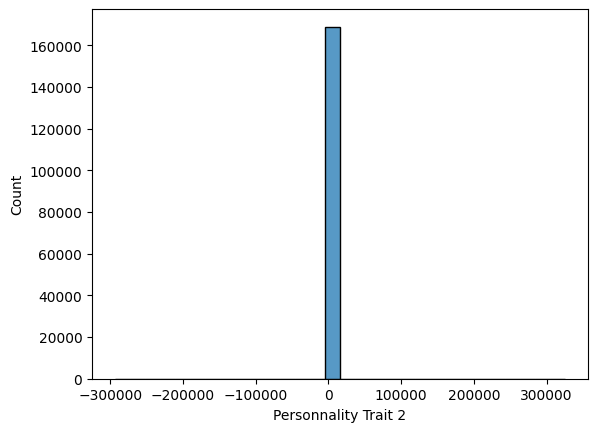

In [40]:
ax = sns.histplot(df["Personnality Trait 2"] , bins = 30 , kde = False)

In [41]:
debut_band_ranking = df.pivot_table(index = ["Personality Trait New"] , columns = "Concert Enjoyment" ,fill_value=0, values ="Id" , aggfunc= "count", observed=False)
debut_band_ranking["All"] = debut_band_ranking.sum(axis=1)
debut_band_ranking = debut_band_ranking.div(debut_band_ranking["All"] , axis = 0)
debut_band_ranking["Positive Experience"] = (debut_band_ranking["Best Concert Ever"] + debut_band_ranking["Enjoyed"])
debut_band_ranking = debut_band_ranking.sort_values(by="Positive Experience", ascending=False)
debut_band_ranking.style.format(format_dict)

Concert Enjoyment,Best Concert Ever,Did Not Enjoy,Enjoyed,Worst Concert Ever,All,Positive Experience
Personality Trait New,,,,,,
0.3 - 0.4,11%,38%,42%,9%,100%,53%
0.8 - 0.9,11%,39%,41%,9%,100%,52%
0.9 - 1.0,11%,38%,40%,10%,100%,51%
0.0 - 0.1,11%,39%,40%,10%,100%,51%
0.4 - 0.5,10%,41%,40%,9%,100%,50%
0.2 - 0.3,9%,41%,40%,10%,100%,50%
0.7 - 0.8,9%,41%,40%,10%,100%,49%
0.5 - 0.6,9%,40%,40%,11%,100%,49%
0.1 - 0.2,10%,41%,39%,11%,100%,49%


#### Conclusion:
- Personality Trait 2 seems to be incorrect because it contains outliers, so we would have to work on this during the preprocessing.

## 1.4 Exploring Concerts Column

### 1.4.1 Exploring Rain Column

#### 1.4.1.1 Exploring Rain Column Alone

In [42]:
np.sort(df["Rain"].unique())

array([False, True, nan], dtype=object)

In [43]:
rain_ranking = df.pivot_table(index = ["Rain"] , columns = "Concert Enjoyment" ,fill_value=0, values ="Id" , aggfunc= "count", margins = True, observed=False)
rain_ranking = rain_ranking.div(rain_ranking["All"] , axis = 0)
rain_ranking["Positive Experience"] = (rain_ranking["Best Concert Ever"] + rain_ranking["Enjoyed"])
rain_ranking = rain_ranking.sort_values(by="Positive Experience", ascending=False)
rain_ranking.style.format(format_dict)

Concert Enjoyment,Best Concert Ever,Did Not Enjoy,Enjoyed,Worst Concert Ever,All,Positive Experience
Rain,,,,,,
False,11%,39%,42%,7%,100%,53%
All,10%,40%,40%,10%,100%,50%
True,6%,43%,30%,20%,100%,36%


#### Conclusion:
- Rain affected the rankings of a concert. 

#### 1.4.1.2 Exploring Rain and Inside Venue Columns

In [44]:
rain_ranking = df.pivot_table(index = ["Rain", "Inside Venue"] , columns = "Concert Enjoyment" ,fill_value=0, values ="Id" , aggfunc= "count", observed=False)
rain_ranking["All"] = rain_ranking.sum(axis=1)
rain_ranking = rain_ranking.div(rain_ranking["All"] , axis = 0)
rain_ranking["Positive Experience"] = (rain_ranking["Best Concert Ever"] + rain_ranking["Enjoyed"])
rain_ranking.columns.name = None
rain_ranking = rain_ranking.reset_index().sort_values(by="Positive Experience", ascending=False).reset_index(drop=True)
rain_ranking.style.format(format_dict)

,Rain,Inside Venue,Best Concert Ever,Did Not Enjoy,Enjoyed,Worst Concert Ever,All,Positive Experience
0,True,True,11%,37%,44%,8%,100%,55%
1,False,False,11%,39%,43%,7%,100%,54%
2,False,True,11%,39%,42%,8%,100%,53%
3,True,False,1%,49%,17%,33%,100%,18%


Conclusion:

1.  Rain has an impact on the performance of the concert if it is not Inside venue. 
2.   This shows that we need a column that includes both "Rain" and not "Inside Venue" for our prediction. 

### 1.4.2. Exploring Seated Column

In [45]:
df["Seated"].value_counts().head(10)

Seated
False    84786
True     84382
Name: count, dtype: int64

In [46]:
np.sort(df["Seated"].unique())

array([nan, False, True], dtype=object)

In [47]:
seated_ranking = df.pivot_table(index = ["Seated"] , columns = "Concert Enjoyment" ,fill_value=0, values ="Id" , aggfunc= "count", margins = True )
seated_ranking = seated_ranking.div(seated_ranking["All"] , axis = 0)
seated_ranking_ = seated_ranking

In [48]:
seated_ranking_.style.format(format_dict)

Concert Enjoyment,Best Concert Ever,Did Not Enjoy,Enjoyed,Worst Concert Ever,All
Seated,,,,,
False,10%,41%,38%,11%,100%
True,10%,39%,42%,9%,100%
All,10%,40%,40%,10%,100%


#### Conclusion:
- Being seated affected the ratings but not significantly.

### 1.4.3 Exploring ConcertID column

In [49]:
np.sort(df["Concert ID"].unique())

array([  0.,   1.,   2., ..., 998., 999.,  nan])

In [50]:
concert_ranking = df.pivot_table(index = ["Concert ID"] , columns = "Concert Enjoyment" ,fill_value=0, values ="Id" , aggfunc= "count", margins = True )
concert_ranking = concert_ranking.div(concert_ranking["All"] , axis = 0)
concert_ranking["Positive Experience"] = (concert_ranking["Best Concert Ever"] + concert_ranking["Enjoyed"])
concert_ranking = concert_ranking.sort_values(by="Positive Experience", ascending=False)

Least Ranked Concerts 

In [51]:
concert_ranking.tail(10).style.format(format_dict)

Concert Enjoyment,Best Concert Ever,Did Not Enjoy,Enjoyed,Worst Concert Ever,All,Positive Experience
Concert ID,,,,,,
347.000000,0%,31%,0%,69%,100%,0%
722.000000,0%,13%,0%,87%,100%,0%
610.000000,0%,34%,0%,66%,100%,0%
670.000000,0%,21%,0%,79%,100%,0%
760.000000,0%,18%,0%,82%,100%,0%
270.000000,0%,39%,0%,61%,100%,0%
620.000000,0%,28%,0%,72%,100%,0%
830.000000,0%,47%,0%,53%,100%,0%
935.000000,0%,50%,0%,50%,100%,0%


Top Ranked Concerts

In [52]:
concert_ranking.head(10).style.format(format_dict)

Concert Enjoyment,Best Concert Ever,Did Not Enjoy,Enjoyed,Worst Concert Ever,All,Positive Experience
Concert ID,,,,,,
841.000000,55%,1%,45%,0%,100%,99%
961.000000,54%,1%,45%,0%,100%,99%
139.000000,46%,1%,53%,0%,100%,99%
592.000000,54%,1%,45%,0%,100%,99%
335.000000,39%,1%,61%,0%,100%,99%
879.000000,82%,1%,18%,0%,100%,99%
745.000000,53%,1%,46%,0%,100%,99%
824.000000,68%,1%,31%,0%,100%,99%
777.000000,53%,1%,46%,0%,100%,99%


# 2. Data Preprocessing

## 2.1 Basic Preprocessing

Drop Columns that do not add value to the prediction

In [53]:
cols_to_drop = [
    "Height (cm)",   # No signal + unrealistic distribtution
    "Height", # Created for analysis
    "Personality Trait New", # Created for analysis
    "Age", # Created for analysis
    "Band Debut period" # Created for analysis
]

In [54]:
df = df.drop(columns=cols_to_drop)
df_test = df_test.drop(columns=["Height (cm)"])

In [55]:
numeric_cols = df.select_dtypes(include = np.number).columns.tolist()
categorical_cols = df.select_dtypes(["object" , "category"]).columns.tolist()
numeric_cols.remove('Concert ID')
categorical_cols.append('Concert ID') ## Concert ID is categorical
categorical_cols.append("Rain and not Inside Venue")
categorical_cols.remove("Id")
categorical_cols.remove("Concert Enjoyment")

List of Numeric Columns we have , that will be scaled later from 0 to 1 .

In [56]:
numeric_cols

['Band Debut',
 'Concert Attendance',
 'Personnality Trait 1',
 'Personnality Trait 2',
 'Personnality Trait 3',
 'Personnality Trait 4',
 'Concert Goer Age']

List of Categorical data that will be encoded later as one Hot Columns

In [57]:
categorical_cols

['Band Name',
 'Band Genre',
 'Band Country of Origin',
 'Inside Venue',
 'Rain',
 'Seated',
 'Concert Goer ID',
 'Concert Goer Country of Origin',
 'Concert ID',
 'Rain and not Inside Venue']

## 2.2 Filling in Missing Data


### 2.2.1 Using known data to extrapolate the missing Data

Fill values of "Band Debut" , "Band Genre" and "Band Country Origin" from data already filled using the "Band Name" as index . For example , we already know that the debut of band "x" is 1995 . Same used for the rest of the Columns (Using one column to fill correlated Columns) .

In [58]:
insert_cols = ['Band Name','Band Genre','Band Country of Origin','Concert Goer Country of Origin']
for df_ in [ df, df_test ]:
    for k in range(3):
        pi = df_.pivot_table(index = ["Concert ID","Band Name","Concert Attendance", "Inside Venue","Rain"]  ,fill_value=0, values ="Id" , aggfunc= "count", margins = True ).reset_index().sort_values(by = "Id" , ascending = False)
        columns = ["Band Name","Concert ID", "Inside Venue","Rain"]
        ind = "Concert Attendance"
        for col in columns :
            if col in insert_cols : 
                index_list = df_.loc[(df_[col].isna()) | (df_[col].str.contains("Insert"))][col].index  
            else :
                index_list = df_.loc[(df_[col].isna())][col].index
            for i in index_list: 
                if  pi[pi[ind] == df_.iloc[i][ind]][col].tolist() != [] : 
                    df_.at[i  , col] =  pi[pi[ind] == df_.iloc[i][ind]][col].tolist()[0]


        pi = df_.pivot_table(index = ["Band Name","Band Debut", "Band Genre","Band Country of Origin"]  ,fill_value=0, values ="Id" , aggfunc= "count", margins = True ).reset_index().sort_values(by = "Id" , ascending = False)
        columns = ["Band Debut", "Band Genre","Band Country of Origin"]
        ind = "Band Name"
        for col in columns :
            if col in insert_cols   : 
                index_list = df_.loc[(df_[col].isna()) | (df_[col].str.contains("Insert"))][col].index  
            else :
                index_list = df_.loc[(df_[col].isna())][col].index
            for i in index_list: 
                if  pi[pi[ind] == df_.iloc[i][ind]][col].tolist() != [] : 
                    df_.at[i  , col] =  pi[pi[ind] == df_.iloc[i][ind]][col].tolist()[0]

        ## Same here , we can fill the values "Concert Attendance", "Inside Venue","Rain" from "Concert ID"
        pi = df_.pivot_table(index = ["Concert ID","Band Name","Concert Attendance", "Inside Venue","Rain"]  ,fill_value=0, values ="Id" , aggfunc= "count", margins = True ).reset_index().sort_values(by = "Id" , ascending = False)
        columns = ["Band Name","Concert Attendance", "Inside Venue","Rain"]
        ind = "Concert ID"
        for col in columns :
            if col in insert_cols : 
                index_list = df_.loc[(df_[col].isna()) | (df_[col].str.contains("Insert"))][col].index  
            else :
                index_list = df_.loc[(df_[col].isna())][col].index
            for i in index_list: 
                if  pi[pi[ind] == df_.iloc[i][ind]][col].tolist() != [] : 
                    df_.at[i  , col] =  pi[pi[ind] == df_.iloc[i][ind]][col].tolist()[0]

        ## Again ,same idea , "Concert Goer ID" gives us already ideas about "Concert Goer Age","Concert Goer Country of Origin" and the 4 Personality Traits .
        pi = df_.pivot_table(index = ["Concert Goer ID","Concert Goer Age","Concert Goer Country of Origin","Personnality Trait 1","Personnality Trait 2","Personnality Trait 3","Personnality Trait 4"]  ,fill_value=0, values ="Id" , aggfunc= "count", margins = True ).reset_index().sort_values(by = "Id" , ascending = False)
        columns = ["Concert Goer Age","Concert Goer Country of Origin","Personnality Trait 1","Personnality Trait 2","Personnality Trait 3","Personnality Trait 4"]
        ind = "Concert Goer ID"
        for col in columns :
            if col in insert_cols :
                index_list = df_.loc[(df_[col].isna()) | (df_[col].str.contains("Insert"))][col].index  
            else :
                index_list = df_.loc[(df_[col].isna())][col].index
            for i in index_list: 
                if  pi[pi[ind] == df_.iloc[i][ind]][col].tolist() != [] : 
                    df_.at[i  , col] =  pi[pi[ind] == df_.iloc[i][ind]][col].tolist()[0]

        pi = df_.pivot_table(index = ["Concert Goer ID","Concert Goer Age","Concert Goer Country of Origin","Personnality Trait 1","Personnality Trait 2","Personnality Trait 3","Personnality Trait 4"]  ,fill_value=0, values ="Id" , aggfunc= "count", margins = True ).reset_index().sort_values(by = "Id" , ascending = False)
        columns = ["Concert Goer Age","Concert Goer Country of Origin","Concert Goer ID","Personnality Trait 2","Personnality Trait 3","Personnality Trait 4"]
        ind = "Personnality Trait 1"
        for col in columns :
            if col in insert_cols :
                index_list = df_.loc[(df_[col].isna()) | (df_[col].str.contains("Insert"))][col].index  
            else :
                index_list = df_.loc[(df_[col].isna())][col].index
            for i in index_list: 
                if  pi[pi[ind] == df_.iloc[i][ind]][col].tolist() != [] : 
                    df_.at[i  , col] =  pi[pi[ind] == df_.iloc[i][ind]][col].tolist()[0]

        pi = df_.pivot_table(index = ["Concert Goer ID","Concert Goer Age", "Concert Goer Country of Origin","Personnality Trait 1","Personnality Trait 2","Personnality Trait 3","Personnality Trait 4"]  ,fill_value=0, values ="Id" , aggfunc= "count", margins = True ).reset_index().sort_values(by = "Id" , ascending = False)
        columns = ["Concert Goer Age","Concert Goer Country of Origin","Concert Goer ID","Personnality Trait 1","Personnality Trait 3","Personnality Trait 4"]
        ind = "Personnality Trait 2"
        for col in columns :
            if col in insert_cols :
                index_list = df_.loc[(df_[col].isna()) | (df_[col].str.contains("Insert"))][col].index  
            else :
                index_list = df_.loc[(df_[col].isna())][col].index
            for i in index_list: 
                if  pi[pi[ind] == df_.iloc[i][ind]][col].tolist() != [] : 
                    df_.at[i  , col] =  pi[pi[ind] == df_.iloc[i][ind]][col].tolist()[0]

### 2.2.2 Filling Concert ID and Concert Attendance

Those are the only Columns we couldnt fill with the last approach , we can fill these columns thought by looking at their neighbors by Id , ConcertExperience_1 and ConcertExperience_2 ... all belong to same concert

In [59]:
for df_ in [df , df_test ]:
    index_list = df_.loc[(df_["Concert ID"].isna())].index
    df_["new_Id"] = df_['Id'].str[18:].astype(int)
    for i in index_list : 
        prec = df_.iloc[i]["new_Id"]
        concert_id_list = df_[(df_["new_Id"] >= i-1 ) & (df_["new_Id"] <= i+1 ) ]["Concert ID"].tolist()
        concert_id = max(set(concert_id_list), key=concert_id_list.count)## get most freq elt 
        concert_attendance_list = df_[(df_["new_Id"] >= i-1 ) & (df_["new_Id"] <= i+1 ) ]["Concert Attendance"].tolist()
        concert_attendance = max(set(concert_attendance_list), key=concert_attendance_list.count) ## get most freq elt 
        df_.at[i , "Concert ID" ] = concert_id
        df_.at[i , "Concert Attendance" ] = concert_attendance
    df_.drop(columns = ["new_Id"] , inplace = True)

### 2.2.3 Fixing the outliers from the Personality Trait 2 column

We have noticed from the analysis , that this Column "Trait Personnality 2" have a lot of outlier data , so here we fill it with median values

In [60]:
for df_ in [df, df_test] :
    median = df_['Personnality Trait 2'].median()
    std = df_['Personnality Trait 2'].std()
    outliers = (df_['Personnality Trait 2'] - median).abs() > 5

    for i in df_[outliers].index : 
        df_.at[i , "Personnality Trait 2"] = median

### 2.2.4 Fixing the Seated Column

The Only missing data we still have is from "Seated" Column , there is no way to extrapolate if a concert goer was seated in a concert or not, so we filled the empty cells with False.

In [61]:
df["Seated"] = df["Seated"].fillna(False).astype("boolean")
df_test["Seated"] = df_test["Seated"].fillna(False).astype("boolean")

/var/folders/zx/rhb75yw161jfg5wz76zyrm300000gp/T/ipykernel_2690/2066081763.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Seated"] = df["Seated"].fillna(False).astype("boolean")
/var/folders/zx/rhb75yw161jfg5wz76zyrm300000gp/T/ipykernel_2690/2066081763.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test["Seated"] = df_test["Seated"].fillna(False).astype("boolean")


## 2.2.5 Adding a column for "Raining" and "Not Inside Venue"

From data exploration, we had discovered that when it's raining and the concert is outside , it impacts a lot the Enjoyment of the Concert, so we added this Column.

In [62]:
df["Rain and not Inside Venue"] = df["Rain"] & ~df["Inside Venue"]
df_test["Rain and not Inside Venue"] = df_test["Rain"] & ~df_test["Inside Venue"]

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170000 entries, 0 to 169999
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Id                              170000 non-null  object 
 1   Band Name                       170000 non-null  object 
 2   Band Genre                      170000 non-null  object 
 3   Band Country of Origin          170000 non-null  object 
 4   Band Debut                      170000 non-null  float64
 5   Concert ID                      170000 non-null  float64
 6   Concert Attendance              170000 non-null  float64
 7   Inside Venue                    170000 non-null  object 
 8   Rain                            170000 non-null  object 
 9   Seated                          170000 non-null  boolean
 10  Personnality Trait 1            170000 non-null  float64
 11  Personnality Trait 2            170000 non-null  float64
 12  Personnality Tra

We have finally replaced the missing data with accurate data asides from the Seated Column

## 2.3 Data Transformation

### 2.3.1 Scaling numeric Features to [0,1]

In [64]:
scaler = MinMaxScaler()
scaler.fit_transform(df[numeric_cols])
for df_ in [df, df_test] :
    scaler.fit(df_[numeric_cols])
    df_[numeric_cols] = scaler.transform(df_[numeric_cols])
df[numeric_cols].describe()

,Band Debut,Concert Attendance,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age
count,170000.000000,1.700000e+05,170000.000000,170000.000000,170000.000000,170000.000000,170000.000000
mean,0.523730,1.667777e-04,0.467121,0.530798,0.494811,0.462319,0.516311
std,0.277392,1.005924e-02,0.146883,0.119351,0.152601,0.141348,0.291200
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.355932,2.144341e-07,0.368051,0.450067,0.389448,0.363747,0.266667
50%,0.559322,1.797805e-06,0.466009,0.530768,0.498970,0.463844,0.516667
75%,0.728814,1.350013e-05,0.566046,0.611612,0.600768,0.560236,0.783333
max,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000


All the numerical columns are now scaled from 0 to 1

### 2.3.2 One Hot Encoding for the Categorical Columns

In [65]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown = 'ignore')
encoder.fit(df[categorical_cols])

encoded_train = encoder.transform(df[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)

df_encoded_train = pd.DataFrame(
    encoded_train,
    columns=encoded_cols,
    index=df.index
)

df = pd.concat(
    [df.drop(columns=categorical_cols), df_encoded_train],
    axis=1
)

encoded_test = encoder.transform(df_test[categorical_cols])

df_encoded_test = pd.DataFrame(
    encoded_test,
    columns=encoded_cols,
    index=df_test.index
)

df_test = pd.concat(
    [df_test.drop(columns=categorical_cols), df_encoded_test],
    axis=1
)

### 2.3.3 Ordinal Encoding for the Target (Concert Enjoyment)

In [66]:
categories_order = [['Worst Concert Ever', 'Did Not Enjoy', 'Enjoyed', 'Best Concert Ever']]

Or_encoder = OrdinalEncoder(categories=categories_order)
df['Concert_Enjoyment_ord'] = Or_encoder.fit_transform(df[['Concert Enjoyment']]).astype(int)

print(df[['Concert Enjoyment', 'Concert_Enjoyment_ord']].head())

    Concert Enjoyment  Concert_Enjoyment_ord
0       Did Not Enjoy                      1
1             Enjoyed                      2
2       Did Not Enjoy                      1
3  Worst Concert Ever                      0
4       Did Not Enjoy                      1


In [67]:
df.columns

Index(['Id', 'Band Debut', 'Concert Attendance', 'Personnality Trait 1',
       'Personnality Trait 2', 'Personnality Trait 3', 'Personnality Trait 4',
       'Concert Goer Age', 'Concert Enjoyment',
       'Band Name_A Dozen Running Iced Frogs',
       ...
       'Concert ID_993.0', 'Concert ID_994.0', 'Concert ID_995.0',
       'Concert ID_996.0', 'Concert ID_997.0', 'Concert ID_998.0',
       'Concert ID_999.0', 'Rain and not Inside Venue_False',
       'Rain and not Inside Venue_True', 'Concert_Enjoyment_ord'],
      dtype='object', length=3233)

All the categorical columns have been transformed with onehot Encoders for example, we now have columns like 'Concert ID_992' 

# 3. Splitting Dataset into Training and Validation Set


In [68]:
# target_col = "Concert Enjoyment"
target_col = "Concert_Enjoyment_ord"

train_val_df, test_df = train_test_split(df, test_size=0.04, random_state=42)

# exclude target from inputs
#input_cols = [c for c in train_val_df.columns if c != target_col]
input_cols = [c for c in train_val_df.columns if c != target_col and c!="Concert Enjoyment"]

train_df, val_df = train_test_split(train_val_df, test_size=0.04, random_state=42)

train_inputs  = train_df[input_cols].copy()
train_targets = train_df[target_col]

val_inputs  = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs  = test_df[input_cols].copy()
test_targets = test_df[target_col]

del train_df, val_df, test_df, train_val_df

feature_cols = list(numeric_cols) + list(encoded_cols)

X_train = train_inputs[feature_cols]
X_val   = val_inputs[feature_cols]
X_test  = test_inputs[feature_cols]

del train_inputs, val_inputs, test_inputs


In [69]:
print("train shape : " , X_train.shape)
print("valid shape : " , X_val.shape)
print("test shape : " , X_test.shape)

train shape :  (156672, 3230)
valid shape :  (6528, 3230)
test shape :  (6800, 3230)


## 4. Model Building

### 4.1 Baseline Classifier: Mord Ordinal Ridge Classifier

Ordinal Ridge regression was chosen as the base model because the target variable is ordinal and the dataset is high-dimensional, with many features that are likely noisy or weakly informative on their own. The model treats concert enjoyment as a continuous latent score and applies L2 regularization, which helps stabilize learning and prevents overfitting in this setting. Mord’s Ordinal Ridge builds directly on scikit-learn’s Ridge Regression, making it both efficient and reliable, while naturally respecting the ordering between classes. Given its strong generalization performance and compatibility with ordinal evaluation metrics, it provides a solid and well-justified baseline for this task.

In [70]:
# Initialize the OrdinalRidge classifier
ord_reg = OrdinalRidge()
ord_reg.fit(X_train, train_targets)

OrdinalRidge()

In [71]:
# Evaluate the model on training and validation set.
y_train_pred = ord_reg.predict(X_train)
y_val_pred = ord_reg.predict(X_val)
train_mae = mean_absolute_error(train_targets, y_train_pred)
train_mse = mean_squared_error(train_targets, y_train_pred)
train_qwk = cohen_kappa_score(train_targets, y_train_pred)
val_mae = mean_absolute_error(val_targets, y_val_pred)
val_mse = mean_squared_error(val_targets, y_val_pred)
val_qwk = cohen_kappa_score(val_targets, y_val_pred)

# Print the evaluation metrics
print("Ordinal Regression Model Evaluation:")
print("="*20)
print(f"Train MAE: {train_mae}")
print(f"Train MSE): {train_mse}")
print(f"Train QWK {train_qwk}\n")
print(f"Val MAE: {val_mae}")
print(f"Val MSE): {val_mse}")
print(f"Val QWK {val_qwk}")

/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OrdinalRidge was fitted without feature names
  warnings.warn(


Ordinal Regression Model Evaluation:
Train MAE: 0.35895373774509803
Train MSE): 0.3650045955882353
Train QWK 0.42990655526280197

Val MAE: 0.37454044117647056
Val MSE): 0.3828125
Val QWK 0.4048441429702405


/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OrdinalRidge was fitted without feature names
  warnings.warn(


The result are fair to moderate. So, we'll run a hyperparameter tuning to check if the model can improve

In [71]:
# Defining the hyperparameters
param_dist = {"alpha": np.logspace(-6, 4, 50)}  

# Perform the hyperparameter search on the training data
rs = RandomizedSearchCV(
    estimator=OrdinalRidge(),
    param_distributions=param_dist,
    n_iter=30,                 
    scoring="neg_mean_absolute_error",
    cv=3,                     
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rs.fit(X_train, train_targets)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OrdinalRidge was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OrdinalRidge was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OrdinalRidge was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OrdinalRidge was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OrdinalRidge was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/torch/lib/python3.9/site-pack

RandomizedSearchCV(cv=3, estimator=OrdinalRidge(), n_iter=30, n_jobs=-1,
                   param_distributions={'alpha': array([1.00000000e-06, 1.59985872e-06, 2.55954792e-06, 4.09491506e-06,
       6.55128557e-06, 1.04811313e-05, 1.67683294e-05, 2.68269580e-05,
       4.29193426e-05, 6.86648845e-05, 1.09854114e-04, 1.75751062e-04,
       2.81176870e-04, 4.49843267e-04, 7.19685673e-04, 1.15139540e-03,
       1.842...
       5.17947468e-01, 8.28642773e-01, 1.32571137e+00, 2.12095089e+00,
       3.39322177e+00, 5.42867544e+00, 8.68511374e+00, 1.38949549e+01,
       2.22299648e+01, 3.55648031e+01, 5.68986603e+01, 9.10298178e+01,
       1.45634848e+02, 2.32995181e+02, 3.72759372e+02, 5.96362332e+02,
       9.54095476e+02, 1.52641797e+03, 2.44205309e+03, 3.90693994e+03,
       6.25055193e+03, 1.00000000e+04])},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

In [ ]:
best_model = rs.best_estimator_
print("Best alpha:", rs.best_params_["alpha"])
print("Best CV MAE:", -rs.best_score_)

y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)

Best alpha: 8.68511373751352
Best CV MAE: 0.3702384599673203


/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OrdinalRidge was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OrdinalRidge was fitted without feature names
  warnings.warn(


In [73]:
# Evaluate the tuned model on validation set
train_mae = mean_absolute_error(train_targets, y_train_pred)
train_mse = mean_squared_error(train_targets, y_train_pred)
train_qwk = cohen_kappa_score(train_targets, y_train_pred)
val_mae = mean_absolute_error(val_targets, y_val_pred)
val_mse = mean_squared_error(val_targets, y_val_pred)
val_qwk = cohen_kappa_score(val_targets, y_val_pred)

# Print the tuned evaluation metrics
print("Ordinal Regression Model Evaluation:")
print("="*35)
print(f"Tuned Train MAE: {train_mae}")
print(f"Tuned Train MSE): {train_mse}")
print(f"Tuned Train QWK {train_qwk}\n")
print(f"Tuned Val MAE: {val_mae}")
print(f"Tuned Val MSE): {val_mse}")
print(f"Tuned Val QWK {val_qwk}")

Ordinal Regression Model Evaluation:
Tuned Train MAE: 0.35989200367647056
Tuned Train MSE): 0.366070516748366
Tuned Train QWK 0.4272443380461918

Tuned Val MAE: 0.3704044117647059
Tuned Val MSE): 0.3783700980392157
Tuned Val QWK 0.41002971429676827


#### Prediction on Test Set

In [74]:
# Evaluate the tuned model on test set
y_test_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(test_targets, y_test_pred)
test_mse = mean_squared_error(test_targets, y_test_pred)
test_qwk = cohen_kappa_score(test_targets, y_test_pred)

# Print the test evaluation metrics
print("Ordinal Regression Model Evaluation:")
print("="*35)
print(f"Test MAE: {test_mae}")
print(f"Test MSE): {test_mse}")
print(f"Test QWK {test_qwk}\n")

Ordinal Regression Model Evaluation:
Test MAE: 0.3735294117647059
Test MSE): 0.3811764705882353
Test QWK 0.41065377950428483



/opt/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OrdinalRidge was fitted without feature names
  warnings.warn(


#### Conclusion
- The Mord Ordinal Ridge classifier provides a reasonable baseline for predicting concert enjoyment and is able to capture the ordinal structure of the target variable.
- However, its performance remains limited, with only marginal improvements observed through hyperparameter tuning, suggesting that a linear ordinal formulation may not be sufficient to fully capture the complexity of the data.
- Although L2 regularization mitigates issues related to multicollinearity, the presence of many correlated and potentially noisy features may require models with greater expressive power.
- As a result, more flexible ordinal models are explored to assess whether they can better model non-linear relationships and improve predictive performance.

### 4.2. Ordinal SVM classifier

In [73]:
svm_clf = LinearSVC()

svm_clf.fit(X_train, train_targets)

# Predictions
y_train_pred = svm_clf.predict(X_train)
y_val_pred   = svm_clf.predict(X_val)


# Evaluation
train_mae = mean_absolute_error(train_targets, y_train_pred)
train_mse = mean_squared_error(train_targets, y_train_pred)
train_qwk = cohen_kappa_score(train_targets, y_train_pred)
val_mae = mean_absolute_error(val_targets, y_val_pred)
val_mse = mean_squared_error(val_targets, y_val_pred)
val_qwk = cohen_kappa_score(val_targets, y_val_pred)

# Print the evaluation metrics
print("SVM Evaluation:")
print("="*25)
print(f"SVM Train MAE: {train_mae}")
print(f"SVM Train MSE: {train_mse}")
print(f"SVM Train QWK {train_qwk}\n")
print(f"SVM Val MAE: {val_mae}")
print(f"SVM Val MSE: {val_mse}")
print(f"SVM Val QWK {val_qwk}")


SVM Evaluation:
SVM Train MAE: 0.3652854370915033
SVM Train MSE: 0.37502553104575165
SVM Train QWK 0.42010110002343237

SVM Val MAE: 0.3779105392156863
SVM Val MSE: 0.38985906862745096
SVM Val QWK 0.39996631479419176


#### Conclusion
- There is no visible improvement with the SVC. So we'll explore deep learning ordinal models to solve this task.